# **Trading System Project: Stock sentiment analysis**

### **Install and import libraries**

In [ ]:
!pip install -U textblob

In [ ]:
# Import libraries
import os
import random
import re
import string
import warnings
warnings.filterwarnings(action ="ignore")


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import numpy as np
import pandas as pd
import scipy 

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU, Bidirectional

In [ ]:
# download stopwords
nltk.download('all')

### **Import data and EDA**

In [ ]:
## Import file 
from google.colab import files
files.upload()

In [ ]:
# Get data into a dataframe
df = pd.read_csv("Tweets_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweets  14993 non-null  object
dtypes: object(1)
memory usage: 117.3+ KB


In [ ]:
print(f" Data Shape: {df.shape}")
df.head(10)

 Data Shape: (15000, 1)


,Tweets
0,fdx trade the us stock market before they...
1,fubo trade the us stock market before they...
2,beat trade the us stock market before they...
3,here we go doge to the moonif you have any dis...
4,bkr trade the us stock market before they...
5,pypl trade the us stock market before they...
6,lumn trade the us stock market before they...
7,pcg trade the us stock market before they ...
8,dkng trade the us stock market before they...
9,gold trade the us stock market before the...


In [ ]:
df.describe()

,Tweets
count,14993
unique,12718
top,reading gt twitters sentiment of the stock ma...
freq,233


In [ ]:
# Detection duplicate value
duplicate_value = df.duplicated().sum()

print(f"In this dataset there are {duplicate_value} duplicate values")

In this dataset there are 1615 duplicate values


In [ ]:
# Drop duplicate values
df.drop_duplicates(inplace= True)

In [ ]:
## Missing values
print(df.isnull().sum())
##
df.dropna(inplace=True)
# shape
print(f" Dataframe Shape:{df.shape}")

Tweets    7
dtype: int64
 Dataframe Shape:(14993, 1)


### **Data preprocessing**

- Lemmatizer
- Remove Stopword
- Get sentiment(target variables)
- Split the data into train, val and test set
- Tokenizer
- Get sequuences and Padding
- paramenters:
  - vocab_size = 10000
  - max_length = 200
  - embedding_dim = 16
  - trunc_type='post'
  - padding_type='post'
  - oov_tok = OOV
 

In [ ]:
# Text lemmatizer and remove stopwords
# English stopwords
eng_stopword = stopwords.words("english")
# intance lemmatize class
lem = WordNetLemmatizer()
#
df["Tweets"] = df["Tweets"].apply(lambda x: " ".join([word for word in x.split() if lem.lemmatize(word) not in eng_stopword]))
##
df.head(10)

,Tweets
0,fdx trade us stock market hit stock turned any...
1,fubo trade us stock market hit stock turned an...
2,beat trade us stock market hit stock turned an...
3,go doge moonif disposable income id suggest bu...
4,bkr trade us stock market hit stock turned any...
5,pypl trade us stock market hit stock turned an...
6,lumn trade us stock market hit stock turned an...
7,pcg trade us stock market hit stock turned any...
8,dkng trade us stock market hit stock turned an...
9,gold trade us stock market hit stock turned an...


In [ ]:
# Get sentiments (target variables)
def get_subjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def get_polarity(text):
  return TextBlob(text).sentiment.polarity


df['subjectivity'] = df['Tweets'].apply(get_subjectivity)
df['polarity'] = df['Tweets'].apply(get_polarity)

In [ ]:
## Get sentiment from polarity
def get_sentiment(score):
  if score < 0:
    return "negative"
  elif score == 0:
    return "neutro"
  else:
    return "positive"

## Apply funtions to all dataframe
df['sentiment'] = df['polarity'].apply(get_sentiment)
df.head(10)

,Tweets,subjectivity,polarity,sentiment
0,fdx trade us stock market hit stock turned any...,0.0,0.0,neutro
1,fubo trade us stock market hit stock turned an...,0.0,0.0,neutro
2,beat trade us stock market hit stock turned an...,0.0,0.0,neutro
3,go doge moonif disposable income id suggest bu...,0.0,0.0,neutro
4,bkr trade us stock market hit stock turned any...,0.0,0.0,neutro
5,pypl trade us stock market hit stock turned an...,0.0,0.0,neutro
6,lumn trade us stock market hit stock turned an...,0.0,0.0,neutro
7,pcg trade us stock market hit stock turned any...,0.0,0.0,neutro
8,dkng trade us stock market hit stock turned an...,0.0,0.0,neutro
9,gold trade us stock market hit stock turned an...,0.0,0.0,neutro


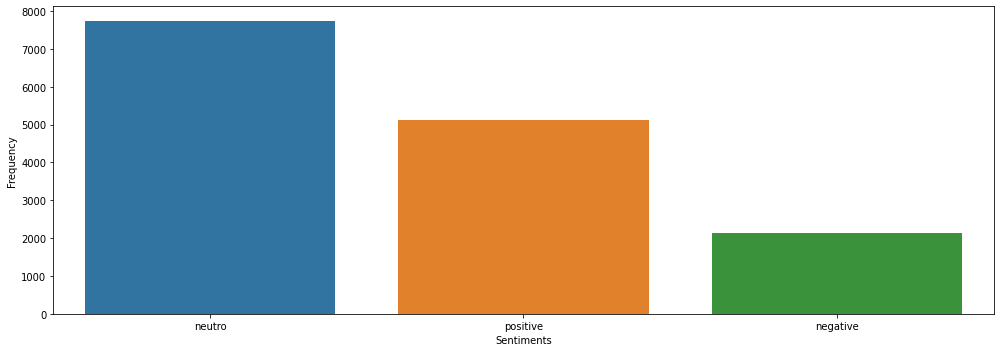

In [ ]:
# labels plot 
fig, ax = plt.subplots(figsize = (14, 5))
sns.countplot(data = df, x = 'sentiment', ax = ax)
#ax.set_yscale("log")
ax.set_ylabel("Frequency")
ax.set_xlabel("Sentiments")
plt.tight_layout();

In [ ]:
## Drop columns 
df.drop(columns =["subjectivity", "polarity"], inplace= True)

In [ ]:
# transform target vairable 
dict_tar = {
    "neutro" : 2,
    "positive" : 1,
    "negative" : 0  
}
df['sentiment'] = df['sentiment'].map(dict_tar) 

In [ ]:
# Split data into Features and label
label = "sentiment"
features = df.drop(columns = label)
sentences = list(features["Tweets"])
labels = list(df[label])

In [ ]:
# Split data into train, val and test
# 80:10:10
split_thre = int(len(sentences)*0.8)
split_thre_1 = int(len(sentences)*0.9)

# Feature sentences 
training_sentences = sentences[ :split_thre]
val_sentences = sentences[split_thre:split_thre_1]
testing_sentences = sentences[split_thre_1: ]
# label sentences 
training_labels = labels[ :split_thre]
val_labels = labels[split_thre:split_thre_1]
testing_labels = labels[split_thre_1:]
# 
print(f"Training sentences : {len(training_sentences)}")
print(f"Training labels : {len(training_labels)}")
print(f"Validation sentences : {len(val_sentences)}")
print(f"Validation labels : {len(training_labels)}")
print(f"Test sentences : {len(testing_sentences)}")
print(f"Test labels: {len(testing_labels)}")

Training sentences : 11994
Training labels : 11994
Validation sentences : 1499
Validation labels : 11994
Test sentences : 1500
Test labels: 1500


In [ ]:
# Tokenizer funtion
def tokenizer_word(vocabsize:int, max_length:int, embedding_dim:int, trunc_type:str,padding_type:str, oov_tok:str):

  # tokenizer
  tokenizer = tf.keras.preprocessing.text.Tokenizer(
      num_words = vocab_size,
      oov_token = oov_tok
  )
  
  # Fit
  tokenizer.fit_on_texts(training_sentences)

  # Text to sequence

  # Training set
  training_seq = tokenizer.texts_to_sequences(training_sentences)
  training_padded = tf.keras.preprocessing.sequence.pad_sequences(
      training_seq, maxlen = max_length, padding = padding_type,
      truncating = trunc_type
  )
  # Val set
  val_seq = tokenizer.texts_to_sequences(val_sentences)
  val_padded = tf.keras.preprocessing.sequence.pad_sequences(
      val_seq, maxlen = max_length, padding = padding_type,
      truncating = trunc_type
  )
  # Test set
  Testing_seq = tokenizer.texts_to_sequences(testing_sentences)
  Testing_padded = tf.keras.preprocessing.sequence.pad_sequences(
      Testing_seq, maxlen = max_length, padding = padding_type,
      truncating = trunc_type
  )

  # Conver to arrays 
  training_pad = np.array(training_padded)
  y_training = np.array(training_labels)
  val_pad = np.array(val_padded)
  y_val = np.array(val_labels)
  testing_pad = np.array(Testing_padded)
  y_test = np.array(testing_labels)

  return training_pad, y_training, val_pad, y_val, testing_pad,y_test   

In [ ]:
# Parameters
vocab_size = 10000
max_length = 200
embedding_dim = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>" 

training_pad, y_train, val_pad, y_val, testing_pad, y_test = tokenizer_word(
    vocab_size, max_length, embedding_dim, trunc_type, padding_type, oov_tok
)

# Shapes
print(f"Training pad shape : {training_pad.shape}")
print(f"Training labels : {y_train.shape}")
print(f"Validation pad shape : {val_pad.shape}")
print(f"Validation labels : {y_val.shape}")
print(f"Testing pad: {testing_pad.shape}")
print(f"Testing labels: {y_test.shape}")

Training pad shape : (11994, 200)
Training labels : (11994,)
Validation pad shape : (1499, 200)
Validation labels : (1499,)
Testing pad: (1500, 200)
Testing labels: (1500,)


In [ ]:
# Matrix
y_train = tf.keras.utils.to_categorical(y_train, num_classes= 3)
y_val = tf.keras.utils.to_categorical(y_val, num_classes= 3)

## **Modelling**

- RNN Architectures:
 - Bidirectional LSTM
 - Bidirectional GRU

- Optimizer:
 - Nadam(lr/eta = 0.001)

- CallBacks:
 - ReduceLROnPlateau

In [ ]:
### Models struture
def lstm():
  model = tf.keras.Sequential([
    #Embedding layer
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    
    # LSTM and batchnormaliztion layers
    Bidirectional(LSTM(64, return_sequences =True, kernel_initializer = "he_normal", dropout = 0.4)),
    tf.keras.layers.BatchNormalization(),
    Bidirectional(LSTM(64, return_sequences =True, kernel_initializer = "he_normal", dropout = 0.4)),
    tf.keras.layers.BatchNormalization(),
    Bidirectional(LSTM(64, kernel_initializer = "he_normal", dropout = 0.4)),
    tf.keras.layers.BatchNormalization(),

    # # # Dense layer
    # # Dense(500, activation = "relu"),
    # # Dropout(0.2),
    # # Dense(500, activation = "relu"),
    # Dropout(0.2),

    #Output layer
    Dense(3, activation = "softmax")
    ])
  
  return model

def gru():
  model = tf.keras.Sequential([
    #Embedding layer
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    
    # GRU AND batchnormalization layers
    Bidirectional(GRU(64, return_sequences =True, kernel_initializer = "he_normal", dropout = 0.4)),
    tf.keras.layers.BatchNormalization(),
    Bidirectional(GRU(64, return_sequences =True, kernel_initializer = "he_normal", dropout = 0.4)),
    tf.keras.layers.BatchNormalization(),
    Bidirectional(GRU(64, kernel_initializer = "he_normal", dropout = 0.4)),
    tf.keras.layers.BatchNormalization(),
    
    # # Dense layes
    # Dense(500, activation = "relu"),
    # Dropout(0.2),
    # Dense(500, activation = "relu"),
    # Dropout(0.2),
    # Output layer
    Dense(3, activation = "softmax")
    ])
  
  return model  

In [ ]:
from tensorflow.keras.optimizers import Adam, Nadam

In [ ]:
# LSTM model
lstm_model = lstm()

# Summary
lstm_model.summary()

# Compile the model
lstm_model.compile(loss = 'categorical_crossentropy',
              optimizer = Nadam(learning_rate = 0.001),
              metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 16)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 200, 128)         41472     
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 200, 128)         512       
 ormalization)                                                   
                                                                 
 bidirectional_1 (Bidirectio  (None, 200, 128)         98816     
 nal)                                                            
                                                                 
 batch_normalization_1 (Batc  (None, 200, 128)         512       
 hNormalization)                                        

In [ ]:
# LSTM model
gru_model = gru()

# Summary
gru_model.summary()

# Compile the model
gru_model.compile(loss = 'categorical_crossentropy',
              optimizer = Nadam(learning_rate = 0.001),
              metrics = ['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 16)           160000    
                                                                 
 bidirectional_3 (Bidirectio  (None, 200, 128)         31488     
 nal)                                                            
                                                                 
 batch_normalization_3 (Batc  (None, 200, 128)         512       
 hNormalization)                                                 
                                                                 
 bidirectional_4 (Bidirectio  (None, 200, 128)         74496     
 nal)                                                            
                                                                 
 batch_normalization_4 (Batc  (None, 200, 128)         512       
 hNormalization)                                      

In [ ]:
### Training Model

In [ ]:
## Callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, patience = 10, mode = 'min')

In [ ]:
# enable run function eagerly
tf.config.run_functions_eagerly(True)

In [ ]:
# batch size and epochs
batch_size = 128
epochs = 30

In [ ]:
# Training lstm model
hist_lstm = lstm_model.fit(
    training_pad, y_train,
    steps_per_epoch = len(training_pad) // batch_size,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (val_pad, y_val),
    validation_steps = len(val_pad) // batch_size,
    callbacks = [reduce_lr],
    verbose = 2,
)

Epoch 1/30
93/93 - 19s - loss: 1.0365 - accuracy: 0.5613 - val_loss: 1.0438 - val_accuracy: 0.4503 - lr: 0.0010 - 19s/epoch - 206ms/step
Epoch 2/30
93/93 - 15s - loss: 0.6638 - accuracy: 0.7259 - val_loss: 0.9345 - val_accuracy: 0.5547 - lr: 0.0010 - 15s/epoch - 165ms/step
Epoch 3/30
93/93 - 14s - loss: 0.4583 - accuracy: 0.8190 - val_loss: 0.9834 - val_accuracy: 0.6229 - lr: 0.0010 - 14s/epoch - 154ms/step
Epoch 4/30
93/93 - 14s - loss: 0.3088 - accuracy: 0.8846 - val_loss: 0.7585 - val_accuracy: 0.7294 - lr: 0.0010 - 14s/epoch - 154ms/step
Epoch 5/30
93/93 - 14s - loss: 0.2249 - accuracy: 0.9196 - val_loss: 0.5044 - val_accuracy: 0.8061 - lr: 0.0010 - 14s/epoch - 155ms/step
Epoch 6/30
93/93 - 21s - loss: 0.1522 - accuracy: 0.9473 - val_loss: 0.5335 - val_accuracy: 0.8430 - lr: 0.0010 - 21s/epoch - 226ms/step
Epoch 7/30
93/93 - 14s - loss: 0.1070 - accuracy: 0.9635 - val_loss: 0.5487 - val_accuracy: 0.8750 - lr: 0.0010 - 14s/epoch - 154ms/step
Epoch 8/30
93/93 - 14s - loss: 0.0807 - a

In [ ]:
# Training gru model
hist_gru = gru_model.fit(
    training_pad, y_train,
    steps_per_epoch = len(training_pad) // batch_size,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (val_pad, y_val),
    validation_steps = len(val_pad) // batch_size,
    callbacks = [reduce_lr],
    verbose = 2,
)

Epoch 1/30
93/93 - 13s - loss: 1.1150 - accuracy: 0.5087 - val_loss: 0.9227 - val_accuracy: 0.6193 - lr: 0.0010 - 13s/epoch - 140ms/step
Epoch 2/30
93/93 - 13s - loss: 0.7159 - accuracy: 0.6975 - val_loss: 1.0181 - val_accuracy: 0.5256 - lr: 0.0010 - 13s/epoch - 139ms/step
Epoch 3/30
93/93 - 13s - loss: 0.4957 - accuracy: 0.7988 - val_loss: 0.6153 - val_accuracy: 0.7585 - lr: 0.0010 - 13s/epoch - 140ms/step
Epoch 4/30
93/93 - 13s - loss: 0.3490 - accuracy: 0.8624 - val_loss: 0.5578 - val_accuracy: 0.8153 - lr: 0.0010 - 13s/epoch - 141ms/step
Epoch 5/30
93/93 - 13s - loss: 0.2313 - accuracy: 0.9150 - val_loss: 0.4612 - val_accuracy: 0.8665 - lr: 0.0010 - 13s/epoch - 140ms/step
Epoch 6/30
93/93 - 13s - loss: 0.1669 - accuracy: 0.9392 - val_loss: 0.4553 - val_accuracy: 0.8572 - lr: 0.0010 - 13s/epoch - 143ms/step
Epoch 7/30
93/93 - 13s - loss: 0.1231 - accuracy: 0.9569 - val_loss: 0.4088 - val_accuracy: 0.8956 - lr: 0.0010 - 13s/epoch - 140ms/step
Epoch 8/30
93/93 - 13s - loss: 0.0917 - a

#### **Model performance evaluation with the training and val set** 

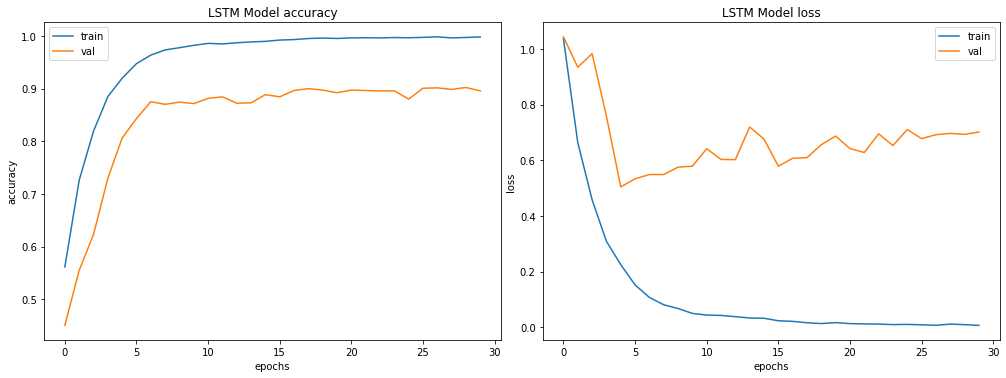

In [ ]:
# LSTM performance
fig, ax = plt.subplots(1,2, figsize =(14,5))
ax.ravel()
plt.tight_layout()

for i, met in enumerate(['accuracy','loss']):
  ax[i].plot(hist_lstm.history[met])
  ax[i].plot(tuple(hist_lstm.history["val_" + met]))
  ax[i].set_title(f"LSTM Model {met}")
  ax[i].set_xlabel("epochs")
  ax[i].set_ylabel(met)
  ax[i].legend(["train", "val"])

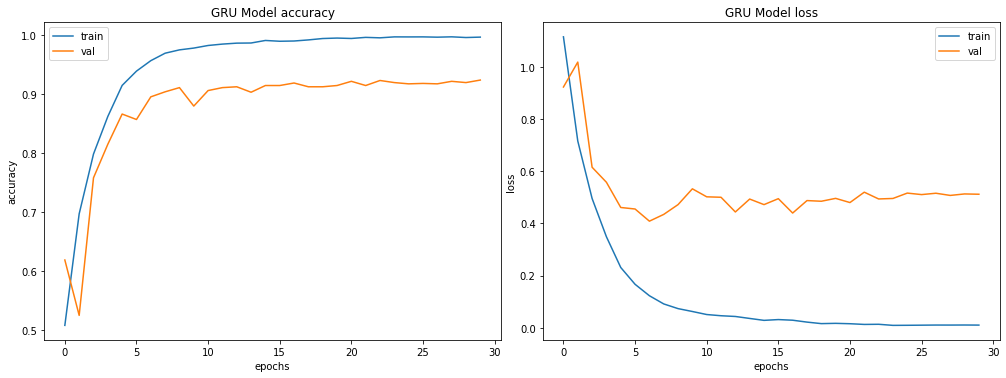

In [ ]:
# GRU performance
fig, ax = plt.subplots(1,2, figsize =(14,5))
ax.ravel()
plt.tight_layout()

for i, met in enumerate(['accuracy','loss']):
  ax[i].plot(hist_gru.history[met])
  ax[i].plot(hist_gru.history["val_" + met])
  ax[i].set_title(f"GRU Model {met}")
  ax[i].set_xlabel("epochs")
  ax[i].set_ylabel(met)
  ax[i].legend(["train", "val"])

#### **Model performance with the test set**

In [ ]:
y_pred = np.argmax(gru_model.predict(testing_pad), axis=-1)

47/47 [==============================] - 2s 41ms/step


Accuracy: 0.911%


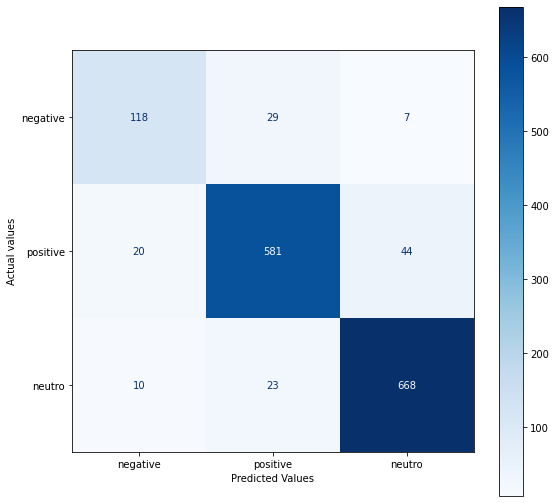

In [ ]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

#print("CONFUSION MATRIX ------------------------------")
fig, ax = plt.subplots(figsize=(9,9))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'Blues', ax = ax)
ax.set_xlabel("Predicted Values")
ax.set_ylabel("Actual values")
ax.xaxis.set_ticklabels(["negative","positive", "neutro"])
ax.yaxis.set_ticklabels(["negative","positive", "neutro"])

## Accuracy and F1-Score
acc_x = accuracy_score(y_test, y_pred)

print(f'Accuracy: {round(acc_x, 3)}%')

### **Save the model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
export_path = '/content/drive/MyDrive/Bitcoin_Tweets/dl_model-0.0.1'
gru_model.save(export_path)